# Проект e-commerce
Ноутбук посвящён изучению данных онлайн-магазина ([источник](https://karpov.courses/analytics)). Были найдены ответы на следующие вопросы и реализованы следующие процедуры:
<br>1. Сколько пользователей совершили покупку только один раз?
<br>2. Сколько заказов в месяц в среднем не доставляются?
<br>3. Для каждого товара определить, в какой день недели он покупается чаще всего.
<br>4. Для каждого пользователя определить среднее количество покупок в неделю с разбивкой по месяцам.
<br>5. Разделить пользователей, совершивших покупки в 2017 году, на когорты по месяцам. Найти когорту с самым высоким показателем retention на 3-й месяц.
<br>6. Выполнить RFM-сегментацию пользователей и провести качественную оценку аудитории.

## Описание данных
### olist_customers_datase.csv - таблица с информацией о клиентах
* *customer_id* - идентификатор клиента в системе.
* *customer_unique_id* - уникальный идентификатор клиента (аналог номера паспорта).
* *customer_zip_code_prefix* - почтовый индекс клиента.
* *customer_city* - город, в котором проживает клиент.
* *customer_state* - штат, в котором проживает клиент.
### olist_orders_dataset.csv - таблица с информацией о заказах
* *order_id* - уникальный идентификатор заказа (номер чека).
* *customer_id* - идентификатор клиента в системе.
* *order_status* - статус заказа; один из _**created (создан), approved (одобрен), invoiced (выставлен счёт), processing (в процессе сборки), shipped (отправлен), delivered (доставлен), unavailable (недоступен), canceled (отменён)**_.
* *order_purchase_timestamp* - время создания заказа.
* *order_approved_at* - время подтверждения оплаты заказа.
* *order_delivered_carrier_date* - время передачи заказа логистической службе.
* *order_delivered_customer_date* - время доставки заказа.
* *order_estimated_delivery_date* - заявленная дата доставки.
### olist_order_items_dataset.csv - таблица с информацией о товарах, входящих в заказы
* *order_id* - уникальный идентификатор заказа (номер чека).
* *order_item_id* - идентификатор товара внутри одного заказа.
* *product_id* - идентификатор товара (аналог штрихкода).
* *seller_id* - идентификатор производителя товара.
* *shipping_limit_date* - максимальная дата поставки продавцом для передачи заказа партнеру по логистике.
* *price* - цена за единицу товара.
* *freight_value* - вес товара.

Таким образом, таблицы **olist_customers_datase.csv** и **olist_orders_dataset.csv** имеют общий ключ *customer_id*, а таблицы **olist_orders_dataset.csv** и **olist_order_items_dataset.csv** - *order_id*

## Импорт библиотек

In [118]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats
from sys import exit

## Чтение данных
Выгрузим данные с Яндекс Диска, воспользовавшись API для получения прямой ссылки на скачивание.

In [119]:
# API
api_url = r'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Публичные URL файлов
customers_url = r'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders_url = r'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
items_url = r'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [120]:
def read_data(public_url, api_url = r'https://cloud-api.yandex.net/v1/disk/public/resources/download?'):
    """
    Считывает данные из CSV файла, сохраненного в облачном хранилище,
    в объект DataFrame библиотеки pandas.
    
    Параметры:
    public_url (str): Публичный URL CSV файла.
    api_url (str): API URL для получения прямого линка на скачивание; по умолчанию
    используется API Яндекс Диска.

    Возвращает:
    pd.DataFrame: DataFrame, содержащий данные из CSV файла.
    """
    response = requests.get(api_url, params={'public_key': public_url})
    # Проверка входных URL.
    if response.status_code != 200:
        print("Something's wrong. Check the public and/or API URL!")
        exit()
    return pd.read_csv(response.json()['href'])

### Customers

In [121]:
customers_df = read_data(customers_url, api_url)
# Выведем первые 5 строк получившегося DataFrame.
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Проверим, есть ли в таблице **customers_df** пропущенные значения.

In [122]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Пропущенные значения отсутствуют. 

### Orders

In [123]:
orders_df = read_data(orders_url, api_url)
# Выведем первые 5 строк получившегося DataFrame.
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Проверим, есть ли в таблице **orders_df** пропущенные значения.

In [124]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Видим, что в таблице есть колонки с NaN-значениями. Выведем эти колонки и посчитаем количество NaNов. 

In [125]:
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**NOTE:** все колонки, содержащие NaN, относятся к временным меткам.

### Items

In [126]:
items_df = read_data(items_url, api_url)
# Выведем первые 5 строк получившегося DataFrame.
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Проверим, есть ли в таблице **items_df** пропущенные значения.

In [127]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Пропущенные значения отсутствуют. 

Удаляем ненужное

In [128]:
del api_url, customers_url, items_url, orders_url 

## Пункт 1
Сколько пользователей совершили покупку только один раз?

Для ответа на этот вопрос необходимо дать определение покупке. 
<br>Обратимся к таблице **orders_df**. Каждая строка данной таблицы соответствует уникальному заказу. Поскольку заказ мог быть отменен или по тем или иным причинам не быть доставлен, нельзя ставить знак равенства между ним и покупкой. Будем считать, что покупка - это "успешный", законченный заказ. 
<br>Какой заказ будет считаться "успешным"? В первую очередь тот, чей *order_status* равен 'delivered'.

In [129]:
temp = orders_df.query("order_status=='delivered'")
temp.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Проверим, остались ли в фильтрованной таблице NaN-значения.

In [130]:
temp.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [131]:
query = ("order_approved_at.isna() or order_delivered_carrier_date.isna() " +
        "or order_delivered_customer_date.isna()")
temp.query(query) \
    [['order_id','order_status', 'order_approved_at',
      'order_delivered_carrier_date', 'order_delivered_customer_date']]

,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN
5323,e04abd8149ef81b95221e88f6ed9ab6a,delivered,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33
16567,8a9adc69528e1001fc68dd0aaebbb54a,delivered,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06
19031,7013bcfc1c97fe719a7b5e05e61c12db,delivered,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38
20618,f5dd62b788049ad9fc0526e3ad11a097,delivered,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN
22663,5cf925b116421afa85ee25e99b4c34fb,delivered,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47
23156,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19
26800,c1d4211b3dae76144deccd6c74144a88,delivered,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01
38290,d69e5d356402adc8cf17e08b5033acfb,delivered,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58
39334,d77031d6a3c8a52f019764e68f211c69,delivered,NaN,2017-02-23 07:23:36,2017-03-02 16:15:23


Видим, что для некоторого числа заказов со статусом 'delivered' минимум одна из колонок *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* содержит NaN.
<br> Будем считать заказ невалидным, а покупку несостоявшейся, если в двух из трех вышеперечисленных колонок записан NaN.

Таким образом, заказ считается покупкой, если:
* *order_status* = 'delivered'.
* Две из трех колонок *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* не содержат NaN.

**Sanity check**: если ли заказы, которые имеют статус отличный от 'delivered' и 'canceled', но в столбец order_delivered_customer_date вписан не NaN?

In [132]:
orders_df.query("order_status not in ['delivered', 'canceled'] and order_delivered_customer_date.notna()")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


Составим таблицу, содержащую покупки.

In [133]:
filtered_orders_df = orders_df.query("order_status=='delivered'") \
    .dropna(axis='index', thresh=len(orders_df.columns)-1)

In [134]:
filtered_orders_df.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      1
order_delivered_customer_date     7
order_estimated_delivery_date     0
dtype: int64

Sanity check: order_id 2d858f451373b04fb5c984a1cc2defaf должен был быть отфильтрован.

In [135]:
filtered_orders_df[filtered_orders_df['order_id']=='2d858f451373b04fb5c984a1cc2defaf']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


В исходных данных каждому клиенту было присвоено два уровня идентификаторов: *customer_unique_id*, уникальный идентификатор клиента из таблицы **customers_df**, и *customer_id*, количество которых соответствует числу созданных клиентом заказов.
<br>Чтобы определить, сколько пользователей совершили ровно одну покупку, нужно:
1. Объединить таблицу успешных заказов **filtered_orders_df** с **customers_df**, содержащей информацию о клиентах, по стобцу *customer_id* - так будут найдены все покупки, совершенные клиентом.

In [136]:
merged_df = pd.merge(
    left=filtered_orders_df, right=customers_df, how="inner", on="customer_id"
)[["customer_id", "customer_unique_id"]]  # выберем только релевантные столбцы
merged_df.head()

,customer_id,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6


2. Отфильтровать всех неудовлетворяющих условию клиентов и посчитать число строк в результирующей таблице.

In [137]:
# Группируем по уникальному ID клиента, считаем число соответствующих ему
# customer_id - то есть, количество сделанных клиентом заказов. 
# Выбираем клиентов с одним заказом.
final_df = merged_df.groupby(by='customer_unique_id', as_index=False) \
    .agg({'customer_id':'count'}) \
    .rename(columns={'customer_id': 'N'}) \
    .query('N==1')
# Sanity Check: в колонке должно быть одно уникальное значение - единица.
final_df['N'].unique()

array([1])

In [138]:
print('Количество клиентов, совершивших ровно одну покупку, равно',
      final_df.shape[0])

Количество клиентов, совершивших ровно одну покупку, равно 90556


In [139]:
# Удаляем ненужное
del temp, filtered_orders_df, final_df, merged_df, query

## Пункт 2
Сколько заказов в месяц в среднем не доставляются?

Если заказ (строка таблицы **orders_df**) имеет *order_status* 'unavailable' (недоступен) или 'canceled' (отменён), то будем считать, что он не мог и не может быть доставлен. То есть, даже если заказ был привезён покупателю (т.е., имеет значение в колонке *order_delivered_carrier_date*), но при этом имеет статус 'canceled', он причисляется к недоставленным (= покупатель не принял свою посылку). 

In [140]:
unavailable_df = orders_df.query("order_status=='unavailable'")
unavailable_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609 entries, 266 to 99415
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       609 non-null    object
 1   customer_id                    609 non-null    object
 2   order_status                   609 non-null    object
 3   order_purchase_timestamp       609 non-null    object
 4   order_approved_at              609 non-null    object
 5   order_delivered_carrier_date   0 non-null      object
 6   order_delivered_customer_date  0 non-null      object
 7   order_estimated_delivery_date  609 non-null    object
dtypes: object(8)
memory usage: 42.8+ KB


Заказы со статусом 'unavailable' не передаются в логистическую службу и, соответственно, не доставляются покупателям.

In [141]:
unavailable_df.query("order_delivered_carrier_date.notna()")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


Можно предположить, что статус 'unavailable' означает отсутствие требуемых товаров на складе.

In [142]:
canceled_df = orders_df.query("order_status=='canceled'")
canceled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625 entries, 397 to 99347
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       625 non-null    object
 1   customer_id                    625 non-null    object
 2   order_status                   625 non-null    object
 3   order_purchase_timestamp       625 non-null    object
 4   order_approved_at              484 non-null    object
 5   order_delivered_carrier_date   75 non-null     object
 6   order_delivered_customer_date  6 non-null      object
 7   order_estimated_delivery_date  625 non-null    object
dtypes: object(8)
memory usage: 43.9+ KB


Заказ может получить статус 'canceled':
* после транспортировки до клиента (6/625, ~1%)

In [143]:
type_1 = canceled_df.query("order_delivered_customer_date.notna()")
type_1.loc[:, 'order_status'] = type_1['order_status'] \
    .apply(lambda x: 'canceled, type 1')
type_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 2921 to 94399
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       6 non-null      object
 1   customer_id                    6 non-null      object
 2   order_status                   6 non-null      object
 3   order_purchase_timestamp       6 non-null      object
 4   order_approved_at              6 non-null      object
 5   order_delivered_carrier_date   6 non-null      object
 6   order_delivered_customer_date  6 non-null      object
 7   order_estimated_delivery_date  6 non-null      object
dtypes: object(8)
memory usage: 432.0+ bytes


* после передачи в логистическую службу, но до доставки (69/625, 11%)

In [144]:
type_2 = canceled_df.query("order_delivered_carrier_date.notna() and order_delivered_customer_date.isna()")
type_2.loc[:, 'order_status'] = type_2['order_status'] \
    .apply(lambda x: 'canceled, type 2')
type_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 613 to 98397
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       69 non-null     object
 1   customer_id                    69 non-null     object
 2   order_status                   69 non-null     object
 3   order_purchase_timestamp       69 non-null     object
 4   order_approved_at              69 non-null     object
 5   order_delivered_carrier_date   69 non-null     object
 6   order_delivered_customer_date  0 non-null      object
 7   order_estimated_delivery_date  69 non-null     object
dtypes: object(8)
memory usage: 4.9+ KB


* до передачи в логистическую службу, но после подтверждения (409/625, ~65%)

In [145]:
type_3 = canceled_df.query("order_delivered_carrier_date.isna() and order_approved_at.notna()")
type_3.loc[:, 'order_status'] = type_3['order_status'] \
    .apply(lambda x: 'canceled, type 3')
type_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, 397 to 99143
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       409 non-null    object
 1   customer_id                    409 non-null    object
 2   order_status                   409 non-null    object
 3   order_purchase_timestamp       409 non-null    object
 4   order_approved_at              409 non-null    object
 5   order_delivered_carrier_date   0 non-null      object
 6   order_delivered_customer_date  0 non-null      object
 7   order_estimated_delivery_date  409 non-null    object
dtypes: object(8)
memory usage: 28.8+ KB


* до подтверждения (141/625, ~23%)

In [146]:
type_4 = canceled_df.query("order_approved_at.isna()")
type_4.loc[:, 'order_status'] = type_4['order_status'] \
    .apply(lambda x: 'canceled, type 4')
type_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, 1130 to 99347
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       141 non-null    object
 1   customer_id                    141 non-null    object
 2   order_status                   141 non-null    object
 3   order_purchase_timestamp       141 non-null    object
 4   order_approved_at              0 non-null      object
 5   order_delivered_carrier_date   0 non-null      object
 6   order_delivered_customer_date  0 non-null      object
 7   order_estimated_delivery_date  141 non-null    object
dtypes: object(8)
memory usage: 9.9+ KB


Для удобста объединим DataFrame **unavailable_df**, **canceled_df**, **type_1**, **type_2**, **type_3**, **type_4** в одну таблицу и выберем только релевантные столбцы.

In [147]:
merged_df = pd.concat([unavailable_df, canceled_df, type_1,
                       type_2, type_3, type_4], axis='index') \
    [['order_id', 'order_status', 'order_purchase_timestamp']]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859 entries, 266 to 99347
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  1859 non-null   object
 1   order_status              1859 non-null   object
 2   order_purchase_timestamp  1859 non-null   object
dtypes: object(3)
memory usage: 58.1+ KB


Для последующего усреднения заказов по месяцам преобразуем строковые значения из столбца *order_purchase_timestamp* в формат datetime. Затем, при помощи метода strftime, извлечём из полученных экземпляров класса datetime строки вида "год/месяц" и сохраним их в новый столбец *year_month*.

In [148]:
merged_df['order_purchase_timestamp'] = pd.to_datetime(
    merged_df["order_purchase_timestamp"]
)
merged_df['year_month'] = merged_df['order_purchase_timestamp'] \
    .dt.strftime("%Y/%m")
merged_df.head()

,order_id,order_status,order_purchase_timestamp,year_month
266,8e24261a7e58791d10cb1bf9da94df5c,unavailable,2017-11-16 15:09:28,2017/11
586,c272bcd21c287498b4883c7512019702,unavailable,2018-01-31 11:31:37,2018/01
687,37553832a3a89c9b2db59701c357ca67,unavailable,2017-08-14 17:38:02,2017/08
737,d57e15fb07fd180f06ab3926b39edcd2,unavailable,2018-01-08 19:39:03,2018/01
1160,2f634e2cebf8c0283e7ef0989f77d217,unavailable,2017-09-27 20:55:33,2017/09


In [149]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859 entries, 266 to 99347
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  1859 non-null   object        
 1   order_status              1859 non-null   object        
 2   order_purchase_timestamp  1859 non-null   datetime64[ns]
 3   year_month                1859 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 72.6+ KB


Расчёт количества заказов с релевантными статусами за все присутствующие в данных месяцы. Для удобства результирующая таблица преобразуется с помощью метода pivot. 
Поскольку в итоговой таблице NaN-значения эквивалентны 0, выполним их замену при помощи метода fillna.

In [150]:
date_status_n = merged_df.groupby(by=["year_month", "order_status"], as_index=False) \
    .agg({"order_id": "count"}) \
    .pivot(columns='order_status', index='year_month', values='order_id') \
    .fillna(value=0,) \
    .sort_index()  # сортировка дат по возрастанию
date_status_n.columns.name = 'occurrences'
date_status_n.head()
# Результирующая таблица содержит информацию об отменённых заказах в целом и 
# с разбиением по типам.

occurrences,canceled,"canceled, type 1","canceled, type 2","canceled, type 3","canceled, type 4",unavailable
year_month,,,,,,
2016/09,2.0,0.0,0.0,2.0,0.0,0.0
2016/10,24.0,5.0,0.0,13.0,6.0,7.0
2017/01,3.0,0.0,0.0,2.0,1.0,10.0
2017/02,17.0,0.0,0.0,15.0,2.0,45.0
2017/03,33.0,0.0,0.0,31.0,2.0,32.0


Создадим столбец с общим количеством недоставленных заказов за тот или иной месяц.

In [151]:
date_status_n['total'] = date_status_n[['canceled', 'unavailable']].sum(axis=1)
date_status_n.head()

occurrences,canceled,"canceled, type 1","canceled, type 2","canceled, type 3","canceled, type 4",unavailable,total
year_month,,,,,,,
2016/09,2.0,0.0,0.0,2.0,0.0,0.0,2.0
2016/10,24.0,5.0,0.0,13.0,6.0,7.0,31.0
2017/01,3.0,0.0,0.0,2.0,1.0,10.0,13.0
2017/02,17.0,0.0,0.0,15.0,2.0,45.0,62.0
2017/03,33.0,0.0,0.0,31.0,2.0,32.0,65.0


Визуализируем общее количество неудачных заказов за все месяцы наблюдений. Горизонтальные линии отвечают среднему значению и медиане недоставленных заказов в месяц.

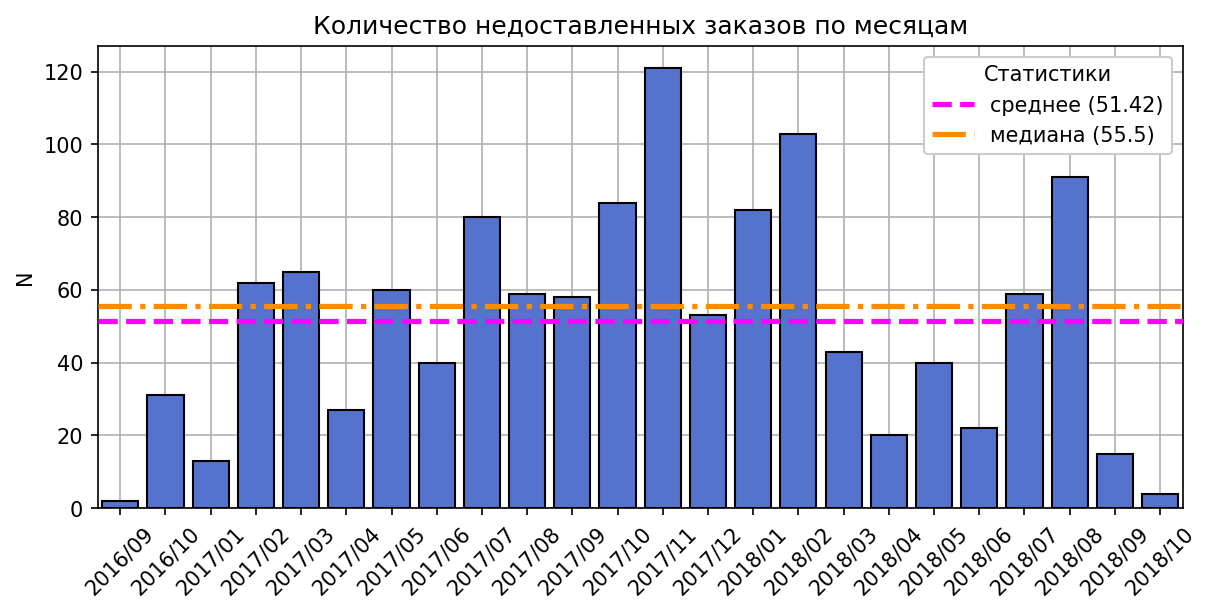

In [152]:
dpi = 150  # явно зададим DPI
fig, ax = plt.subplots(dpi=dpi, figsize=(1400/dpi, 600/dpi))  
ax.axhline(date_status_n['total'].mean(), zorder=3,
           linestyle='--', linewidth=2.5, color='magenta', 
           label=f"среднее ({np.round(date_status_n['total'].mean(), 2)})")
ax.axhline(date_status_n['total'].median(), zorder=3,
           linestyle='-.', linewidth=2.5, color='darkorange',
           label=f"медиана ({np.round(date_status_n['total'].median(), 2)})")
sns.barplot(data=date_status_n, x=date_status_n.index, y='total',
            color="royalblue", edgecolor='black', linewidth=1,
            ax=ax, zorder=2)
ax.set(xlabel='', ylabel='N',
       title='Количество недоставленных заказов по месяцам')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Статистики', framealpha=1)
ax.grid(zorder=1)
plt.show();

Теперь визуализируем:
1. количество недоставленных заказов с разбивкой по статусам 'canceled' / 'unavailable' и месяцам.
2. среднее количество *отмененных* заказов различных типов в месяц.
Горизонтальные линии отвечают средним значениям.

In [153]:
# Разворачивает DataFrame из "широкого формата" в длинный. Он для визуализации в
# seaborn.
df_melted_1 = date_status_n.reset_index() \
    .rename(columns={'index': 'year_month'}) \
    .melt(id_vars='year_month', value_vars=['canceled','unavailable'], 
          var_name='status', value_name='N')
df_melted_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year_month  48 non-null     object 
 1   status      48 non-null     object 
 2   N           48 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.2+ KB


In [154]:
# Разворачивает DataFrame из "широкого формата" в длинный. Он для визуализации в
# seaborn.
df_melted_2 = date_status_n.reset_index() \
    .rename(columns={'index': 'year_month'}) \
    .melt(id_vars='year_month', value_vars=['canceled, type 1',	'canceled, type 2',
                                            'canceled, type 3',	'canceled, type 4'], 
          var_name='status', value_name='N')
df_melted_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year_month  96 non-null     object 
 1   status      96 non-null     object 
 2   N           96 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.4+ KB


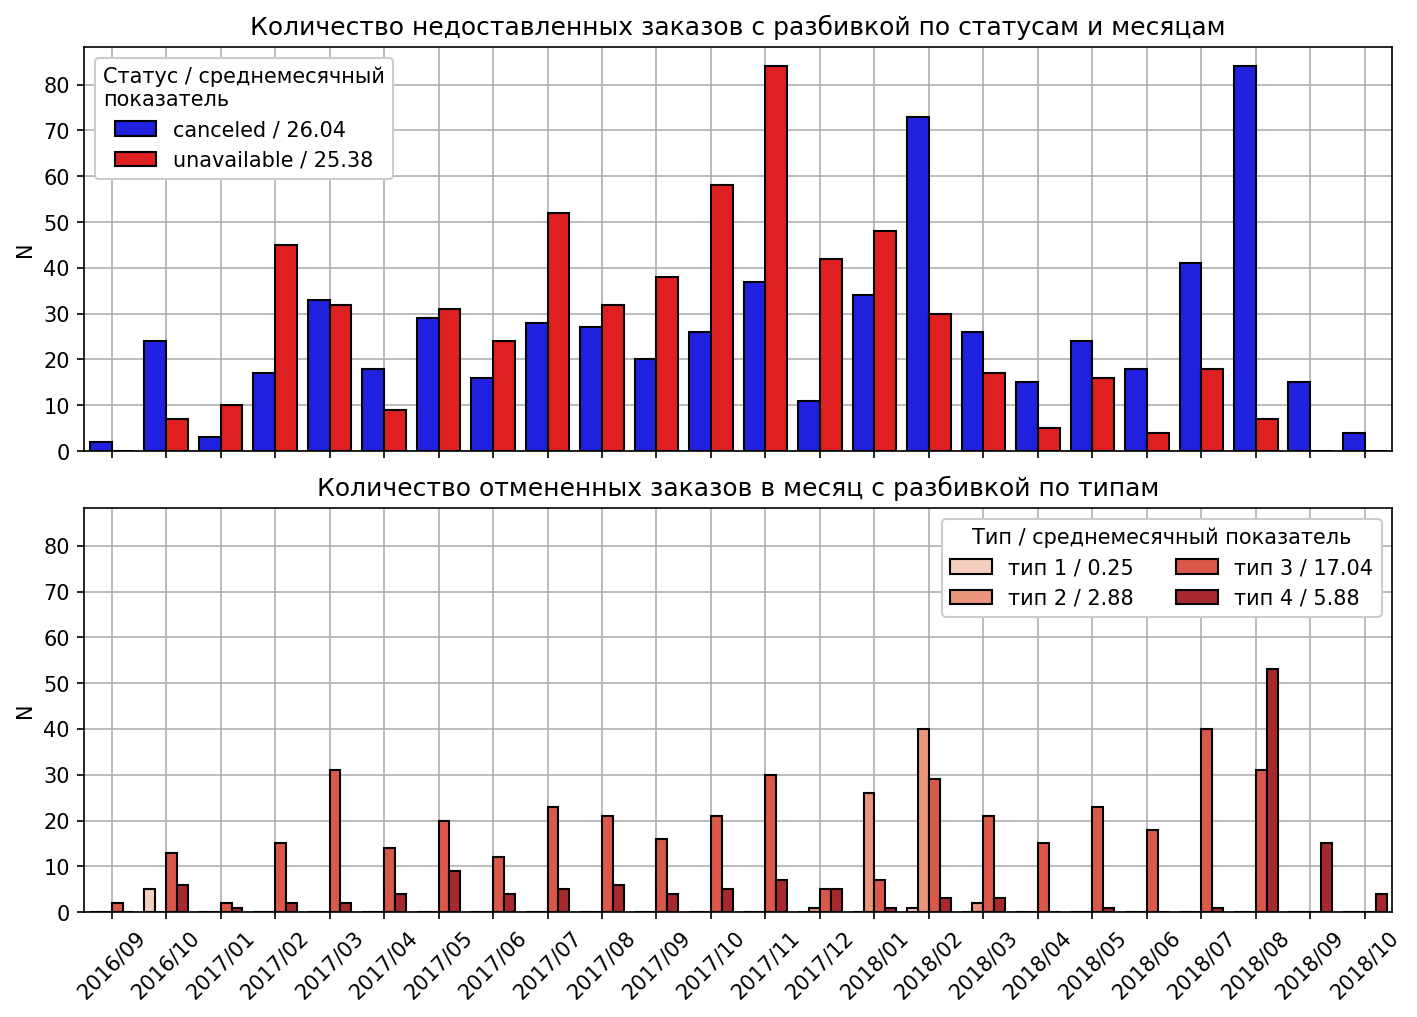

In [155]:
dpi = 150  # явно зададим DPI
fig, ax = plt.subplots(2, 1, dpi=dpi, figsize=(1400/dpi, 1000/dpi), sharex=True,
                       constrained_layout=True)
# 1
sns.barplot(data=df_melted_1, x='year_month', y='N', hue='status',
            palette={'canceled': 'blue', 'unavailable': 'red'}, edgecolor='black', linewidth=1,
            ax=ax[0], zorder=2)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(xlabel='',
          title='Количество недоставленных заказов с разбивкой по статусам и месяцам')
handles, _ = ax[0].get_legend_handles_labels()  # Получение текущих handles и labels
ax[0].legend(handles=handles,
             labels=[f"canceled / {np.round(date_status_n['canceled'].mean(), 2)}",
                     f"unavailable / {np.round(date_status_n['unavailable'].mean(), 2)}"],
             title='Статус / среднемесячный\nпоказатель', framealpha=1)
ax[0].grid(zorder=1)
# 2
sns.barplot(data=df_melted_2, x='year_month', y='N', hue='status',
            palette='Reds', edgecolor='black', linewidth=1,
            ax=ax[1], zorder=2)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(xlabel='',
          title='Количество отмененных заказов в месяц с разбивкой по типам',
          ylim=ax[0].get_ylim())
ax[1].tick_params(axis='x', rotation=45)
handles, _ = ax[1].get_legend_handles_labels()  # Получение текущих handles и labels
ax[1].legend(title='Тип / среднемесячный показатель', handles=handles,
             labels=[f"тип 1 / {np.round(date_status_n['canceled, type 1'].mean(), 2)}",
                     f"тип 2 / {np.round(date_status_n['canceled, type 2'].mean(), 2)}",
                     f"тип 3 / {np.round(date_status_n['canceled, type 3'].mean(), 2)}",
                     f"тип 4 / {np.round(date_status_n['canceled, type 4'].mean(), 2)}"],
             ncols=2,
             framealpha=1)
ax[1].grid(zorder=1)
#
plt.show();

Напомним, чему соответствует тот или иной тип отменённого заказа:
1. Заказ отменён после транспортировки до клиента (6/625, ~1%)
2. Заказ отменён после передачи в логистическую службу, но до доставки (69/625, 11%)
3. Заказ отменён после подтверждения, но до передачи в логистическую службу (409/625, ~65%)
4. Заказ отменён до подтверждения (141/625, ~23%)

Отметим, что ~37% заказов типа 4 приходятся на август 2018 года. Также наблюдается некоторое сходство между нормальным гауссовым распределением и распределением числа unavailable заказов. Проверим эту гипотезу с помощью статистического теста Шапиро-Уилка.

In [156]:
from scipy.stats import shapiro
shapiro(date_status_n['unavailable'])

ShapiroResult(statistic=0.9203386902809143, pvalue=0.05942462384700775)

P-значение превышает порог в 5%, поэтому мы не можем отклонить нулевую гипотезу (данные были взяты из нормального распределения).

In [157]:
# Удаляем ненужное
del (ax, canceled_df, date_status_n, df_melted_1, df_melted_2, dpi, fig, handles,
     merged_df, type_1, type_2, type_3, type_4, unavailable_df)

## Пункт 3
По каждому товару определить, в какой день недели он покупается чаще всего.

Как и в первом задании, будем считать заказ покупкой, если:
* *order_status* = 'delivered'.
* Две из трех колонок *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* не содержат NaN.

Создадим таблицу, содержащую только покупки.

In [158]:
filtered_orders_df = orders_df.query("order_status=='delivered'") \
    .dropna(axis='index', thresh=len(orders_df.columns)-1)

Объединим таблицу покупок с таблицей, содержащей информацию о товарах, которые были куплены; выбирем только релевантные колонки.

In [159]:
merged_df = pd.merge(left=filtered_orders_df, right=items_df,
                     how='inner', on='order_id')[['order_id',
                                                  'order_purchase_timestamp',
                                                  'product_id']]
merged_df.tail()

,order_id,order_purchase_timestamp,product_id
110191,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,f1d4ce8c6dd66c47bbaa8c6781c2a923
110192,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,b80910977a37536adeddd63663f916ad
110193,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4
110194,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4
110195,66dea50a8b16d9b4dee7af250b4be1a5,2018-03-08 20:57:30,006619bbed68b000c8ba3f8725d5409e


In [160]:
merged_df.info()  # Нет NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110196 entries, 0 to 110195
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   order_id                  110196 non-null  object
 1   order_purchase_timestamp  110196 non-null  object
 2   product_id                110196 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


Извлечём день недели из дат в столбце *order_purchase_timestamp* и сохраним результат в новый столбец *weekday*. <br>Удалим *order_purchase_timestamp*.

In [161]:
merged_df['weekday'] = pd.to_datetime(merged_df.order_purchase_timestamp) \
    .dt.strftime('%A')
merged_df.drop(columns='order_purchase_timestamp', inplace=True)
merged_df.head()

,order_id,product_id,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,Tuesday


Подсчитаем, сколько раз покупался тот или иной товар в разные дни недели.

In [162]:
product_purchases = merged_df.groupby(by=['product_id', 'weekday'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'purchases'})
product_purchases.tail(10)

,product_id,weekday,purchases
59942,fff515ea94dbf35d54d256b3e39f0fea,Sunday,1
59943,fff6177642830a9a94a0f2cba5e476d1,Saturday,1
59944,fff6177642830a9a94a0f2cba5e476d1,Sunday,1
59945,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
59946,fff9553ac224cec9d15d49f5a263411f,Friday,1
59947,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59948,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
59949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
59950,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
59951,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1


In [163]:
product_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59952 entries, 0 to 59951
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  59952 non-null  object
 1   weekday     59952 non-null  object
 2   purchases   59952 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


Найдём максимально количество покупок товара за неделю.

In [164]:
product_mpurchases = product_purchases.groupby(by='product_id')['purchases'] \
    .max().reset_index()
product_mpurchases.sort_values(by='purchases', ascending=False).head(10)

,product_id,purchases
8428,422879e10f46682990de24d770e7f83d,93
19289,99a4788cb24856965c36a24e339b6058,91
21616,aca2eb7d00ea1a7b8ebd4e68314663af,89
10615,53b36df67ebb7c41585e8d54d6772e08,76
6925,368c6c730842d78016ad823897a372db,67
7205,389d119b48cf3043d311335e499d9c6b,67
10588,53759a2ecddad2bb87a079a1f1519f73,66
26435,d1c427060a0f73f6b889a5c7c61f2ac4,62
7880,3dd2a17168ec895c781a9191c1e95ad7,53
20821,a62e25e09e05e6faf31d90c6ec1aa3d1,49


Для того, чтобы получить таблицу, в которой будет содержаться информация о максимальном количестве покупок товара *product_id* за день **И** название этого дня, нужно выполнить своеобразный SELF JOIN таблицы **product_purchases** с **product_mpurchases**.
<br>**NOTE**: Если товар X покупался Y раз в каждый из дней недели, мы хотим сохранить в результирующей таблице все 7 строчек.

In [165]:
# Выполняем своеобразный SELF JOIN
final_df = pd.merge(product_purchases, product_mpurchases, 
                    on=['product_id', 'purchases'], how='inner') \
    .sort_values(by='purchases', ascending=False)  # сортировка по кол-ву покупок
final_df.head(15)

,product_id,weekday,purchases
10886,422879e10f46682990de24d770e7f83d,Wednesday,93
24832,99a4788cb24856965c36a24e339b6058,Monday,91
27841,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
13684,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
9242,389d119b48cf3043d311335e499d9c6b,Thursday,67
8875,368c6c730842d78016ad823897a372db,Friday,67
13651,53759a2ecddad2bb87a079a1f1519f73,Wednesday,66
34205,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,62
10132,3dd2a17168ec895c781a9191c1e95ad7,Wednesday,53
26800,a62e25e09e05e6faf31d90c6ec1aa3d1,Thursday,49


In [166]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41774 entries, 10886 to 41773
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  41774 non-null  object
 1   weekday     41774 non-null  object
 2   purchases   41774 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [167]:
# Удаляем ненужное
del product_purchases, product_mpurchases, merged_df, final_df, filtered_orders_df

## Пункт 4
Для каждого пользователя определить среднее количество покупок в неделю с разбивкой по месяцам.
<br>**NOTE**: внутри месяца может быть не целое число недель. Например, в ноябре 2021 года 4,28 недели.

Заказ считается покупкой, если:
* *order_status* = 'delivered'.
* Две из трех колонок *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* не содержат NaN.

Создадим таблицу, содержащую только покупки.

In [168]:
filtered_orders_df = orders_df.query("order_status=='delivered'") \
    .dropna(axis='index', thresh=len(orders_df.columns)-1)

Объединение **filtered_orders_df** с **customers_df** и извлечение только релевантных столбцов:

In [169]:
merged_df = pd.merge(
    left=filtered_orders_df, right=customers_df, how="inner", on="customer_id"
)[["customer_unique_id", "order_id", "order_purchase_timestamp"]]
merged_df.head()

,customer_unique_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


Сконвертируем столбец *order_purchase_timestamp* таблицы **merge_df** из строкового в формат datetime. Затем создадим новые столбцы *year_month*, наполненный строками с датами в формате год-месяц, и *year_month_day*, наполненный строками с датами в формате год-месяц-день.

In [170]:
merged_df['order_purchase_timestamp'] = pd.to_datetime(
    merged_df['order_purchase_timestamp']
)
merged_df['year_month'] = merged_df['order_purchase_timestamp'] \
    .dt.strftime("%Y-%m")
merged_df['year_month_day'] = merged_df['order_purchase_timestamp'] \
    .dt.strftime("%Y-%m-%d")
merged_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,year_month,year_month_day
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,2017-10-02
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02,2018-02-13


Прежде чем приступить к решению поставленной задачи, посмотрим, в каком диапазоне дат находятся имеющиеся данные, а также проверим, есть ли месяцы, в которые покупки совершались не каждый день. 

In [171]:
print(f'Earliest date: {merged_df["order_purchase_timestamp"].min()}, ' +
      f'latest date: {merged_df["order_purchase_timestamp"].max()}')

Earliest date: 2016-09-15 12:16:38, latest date: 2018-08-29 15:00:37


Видим, что в данных записи о покупках начинаются с 15 сентября 2016 года, а заканчиваются 29 июля 2018-го.
<br>Поскольку далее мы будем считать среднее количество покупок в неделю за разные месяцы, а за сентябрь-2016 отсутствует информация о покупках 1-14 числа, отбросим этот месяц из наших построений. 

In [172]:
merged_df = merged_df.query("order_purchase_timestamp >= @pd.Timestamp(year=2016, month=10, day=1)")
# Проверим, изменился ли минимум order_purchase_timestamp
merged_df["order_purchase_timestamp"].min()

Timestamp('2016-10-03 09:44:50')

Теперь рассмотрим другие месяцы. Создадим DataFrame, содержащий все даты от 1 октября 2016 года до 31 июля 2018-го.

In [173]:
column_dt = pd.date_range(start='2016-10-01', end='2018-08-31', freq='D',
                          inclusive='both')
column_str = column_dt.strftime("%Y-%m-%d")
temp = pd.DataFrame(data={"year_month_day": column_str})
temp.head()

,year_month_day
0,2016-10-01
1,2016-10-02
2,2016-10-03
3,2016-10-04
4,2016-10-05


Выполним left join **temp** c **merged_df** по колонке *'year_month_day'*.

Таким образом, результирующая таблица будет содержать строки с NaN во всех колонках, кроме *year_month_day* - это означает, что для текущего дня нет информации о покупках.

In [174]:
extended_merged_df = pd.merge(left=temp, right=merged_df, how='left',
                              on='year_month_day')
extended_merged_df.head()

,year_month_day,customer_unique_id,order_id,order_purchase_timestamp,year_month
0,2016-10-01,NaN,NaN,NaT,NaN
1,2016-10-02,NaN,NaN,NaT,NaN
2,2016-10-03,87776adb449c551e74c13fc34f036105,cd3b8574c82b42fc8129f6d502690c3e,2016-10-03 22:31:31,2016-10
3,2016-10-03,2f64e403852e6893ae37485d5fcacdaf,be5bc2f0da14d8071e2d45451ad119d9,2016-10-03 16:56:50,2016-10
4,2016-10-03,10e89fd8e5c745f81bec101207ba4d7d,ef1b29b591d31d57c0d7337460dd83c9,2016-10-03 22:51:30,2016-10


Сгруппируем таблицу **extended_merged_df** по столбцу *year_month_day* и посчитаем, сколько *order_id* отвечают тому или иному дню. 

*NOTE:* Функция count игнорирует NaN-значения. Видим, что за 2016-10-01 не было совершенно ни одной покупки.

In [175]:
date_purchases = extended_merged_df.groupby(by='year_month_day', as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id':'purchases',})
date_purchases.head()

,year_month_day,purchases
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,7
3,2016-10-04,54
4,2016-10-05,35


Если за какой-то месяц набирается более 14 дней без покупок, отбросим его целиком.

In [176]:
# Подсчет количества дней с нулевыми покупками за месяц
date_purchases['year_month'] = (pd.to_datetime(date_purchases['year_month_day'])) \
    .dt.strftime("%Y-%m")
zero_purchases_count = date_purchases[date_purchases['purchases'] == 0] \
    .groupby('year_month', as_index=False) \
    .agg({'purchases': 'size'}) \
    .rename(columns={'purchases': 'days_without_purchases'})
zero_purchases_count

,year_month,days_without_purchases
0,2016-10,23
1,2016-11,30
2,2016-12,30
3,2017-01,4
4,2018-08,2


In [177]:
# Поиск месяцев с более чем 7 днями без покупок
months_to_delete = zero_purchases_count.query("days_without_purchases > 14")
months_to_delete

,year_month,days_without_purchases
0,2016-10,23
1,2016-11,30
2,2016-12,30


In [178]:
# Отфильтровать эти месяцы из исходного DataFrame
# 1
months_to_delete_list = months_to_delete['year_month'].to_list()
date_purchases = date_purchases.query("year_month not in @months_to_delete_list")
# 2
# date_purchase = date_purchases[~date_purchases['year_month'].isin(months_to_delete['year_month'])]
date_purchases.head()

,year_month_day,purchases,year_month
92,2017-01-01,0,2017-01
93,2017-01-02,0,2017-01
94,2017-01-03,0,2017-01
95,2017-01-04,0,2017-01
96,2017-01-05,32,2017-01


**Sanity check**: пересоздадим таблицу с количеством дней без покупок в месяц.

In [179]:
zero_purchases_count = date_purchases[date_purchases['purchases'] == 0] \
    .groupby('year_month', as_index=False) \
    .agg({'purchases': 'size'}) \
    .rename(columns={'purchases': 'days_without_purchases'})
zero_purchases_count

,year_month,days_without_purchases
0,2017-01,4
1,2018-08,2


Кроме того, мы видим, что в январе 2017 и августе 2018 было некоторое количество дней, в течение которых пользователи не совершали покупки. Также исключим их из **date_purchases**.

In [180]:
date_purchases = date_purchases.query("purchases > 0")
date_purchases.tail()

,year_month_day,purchases,year_month
693,2018-08-25,69,2018-08
694,2018-08-26,73,2018-08
695,2018-08-27,66,2018-08
696,2018-08-28,39,2018-08
697,2018-08-29,11,2018-08


**Sanity check**: пересоздадим таблицу с количеством дней без покупок в месяц.

In [181]:
zero_purchases_count = date_purchases[date_purchases['purchases'] == 0] \
    .groupby('year_month', as_index=False) \
    .agg({'purchases': 'size'}) \
    .rename(columns={'purchases': 'days_without_purchases'})
zero_purchases_count

,year_month,days_without_purchases


Исключим из **merged_df** записи, соответствующие месяцам со слишком большим числом "плохих" дней.

In [182]:
temp = date_purchases['year_month_day'].to_list()
merged_df = merged_df.query("year_month_day in @temp")

In [183]:
merged_df.year_month_day.min()

'2017-01-05'

In [184]:
merged_df.year_month_day.max()

'2018-08-29'

Данные успешно очищены. Перейдем к ответу на поставленный вопрос.

Прежде всего, найдем число покупок, которые совершил каждый пользователь за тот или иной месяц.

In [185]:
final_df = merged_df.groupby(by=["customer_unique_id", "year_month"],
                             as_index=False) \
    .agg({"order_id": "count"}) \
    .rename(columns={"order_id":"monthly_purchases"}) \
    .sort_values(by='monthly_purchases', ascending=False)
final_df.head()

,customer_unique_id,year_month,monthly_purchases
7081,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
65589,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4
67170,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4
23151,3e43e6105506432c953e165fb2acf44c,2018-02,4
14013,25a560b9a6006157838aab1bdbd68624,2017-04,4


Каждому *year_month* поставим в соответствие значения *days_in_month* и *weeks_in_month* - число дней и недель в текущем месяце.

In [186]:
final_df['days_in_month'] = pd.to_datetime(final_df['year_month']).dt.daysinmonth
final_df['weeks_in_month'] = (final_df['days_in_month'] / 7)
final_df.head(10)

,customer_unique_id,year_month,monthly_purchases,days_in_month,weeks_in_month
7081,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,31,4.428571
65589,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,30,4.285714
67170,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,28,4.000000
23151,3e43e6105506432c953e165fb2acf44c,2018-02,4,28,4.000000
14013,25a560b9a6006157838aab1bdbd68624,2017-04,4,30,4.285714
60205,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,28,4.000000
74358,c8460e4251689ba205045f3ea17884a1,2018-08,4,31,4.428571
48986,83e7958a94bd7f74a9414d8782f87628,2017-01,4,31,4.428571
75676,cbd08b04b3f301152b7570da5e9c8cc4,2017-09,3,30,4.285714
43375,74cb1ad7e6d5674325c1f99b5ea30d82,2017-08,3,31,4.428571


Чтобы найти среднее количество покупок, совершенных пользователем в определенном месяце, разделим столбец *purchases* на столбец *weeks_in_month*:

In [187]:
final_df["avg_weekly_purchases"] = (
    final_df["monthly_purchases"] / final_df["weeks_in_month"]
)
final_df.head()

,customer_unique_id,year_month,monthly_purchases,days_in_month,weeks_in_month,avg_weekly_purchases
7081,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,31,4.428571,1.354839
65589,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,30,4.285714,0.933333
67170,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,28,4.000000,1.000000
23151,3e43e6105506432c953e165fb2acf44c,2018-02,4,28,4.000000,1.000000
14013,25a560b9a6006157838aab1bdbd68624,2017-04,4,30,4.285714,0.933333


In [188]:
final_df.sort_values(by='avg_weekly_purchases', ascending=False) \
    .round(3)[['customer_unique_id', 'year_month', 'avg_weekly_purchases',]] \
    .head(10)

,customer_unique_id,year_month,avg_weekly_purchases
7081,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,1.355
67170,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,1.000
23151,3e43e6105506432c953e165fb2acf44c,2018-02,1.000
60205,a239b8e2fbce33780f1f1912e2ee5275,2017-02,1.000
14013,25a560b9a6006157838aab1bdbd68624,2017-04,0.933
65589,b08fab27d47a1eb6deda07bfd965ad43,2017-09,0.933
74358,c8460e4251689ba205045f3ea17884a1,2018-08,0.903
48986,83e7958a94bd7f74a9414d8782f87628,2017-01,0.903
66389,b2bd387fdc3cf05931f0f897d607dc88,2018-02,0.750
78619,d3882d7abd0c66064d740d7ed04dd1ef,2018-02,0.750


In [189]:
# Удаляем ненужное
del (temp, final_df, filtered_orders_df, merged_df, months_to_delete,
     months_to_delete_list, zero_purchases_count, extended_merged_df,
     column_dt, column_str, date_purchases)

## Пункт 5
Разделить пользователей, совершивших покупки в 2017 году, на когорты по месяцам. Найти когорту с самым высоким показателем retention на 3-й месяц.

Мы будем работать только с успешными покупками - заказами, которые удовлетворяют следующим условиям:
* *order_status* = 'delivered'.
* Две из трех колонок *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* не содержат NaN.

Создадим таблицу, содержащую только покупки.

In [190]:
filtered_orders_df = orders_df.query("order_status=='delivered'") \
    .dropna(axis='index', thresh=len(orders_df.columns)-1)
filtered_orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Объединим **filtered_orders_df** с **customers_df**, чтобы создать таблицу вида *уникальный ID пользователя* | *время создания заказа*.

In [191]:
new_df = pd.merge(
    filtered_orders_df, customers_df, how='inner', on='customer_id'
)[['customer_unique_id', 'order_purchase_timestamp']]
new_df.tail()

,customer_unique_id,order_purchase_timestamp
96472,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05
96473,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58
96474,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43
96475,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27
96476,60350aa974b26ff12caad89e55993bd6,2018-03-08 20:57:30


Данные о дате покупки (*order_purchase_timestamp*) хранятся в строковом формате - преобразуем их в формат datetime и сохраним результат в новом столбце *purchase_timestamp*.

In [192]:
new_df['purchase_timestamp'] = pd.to_datetime(new_df['order_purchase_timestamp'])

Создадим столбец *purchase_year_month*, куда в строковом формате внесём год - месяц совершения той или иной покупки.

In [193]:
new_df['purchase_year_month'] = new_df['purchase_timestamp'].dt.strftime('%Y-%m')
# Избавимся от более ненужного столбца
new_df.drop(columns=['order_purchase_timestamp'], inplace=True)
new_df.head()

,customer_unique_id,purchase_timestamp,purchase_year_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02


Определим полную дату совершения первой задокументированной покупки каждого пользователя.

In [194]:
first_purchases = new_df.groupby('customer_unique_id', as_index=False) \
    .agg({'purchase_timestamp': 'min'}) \
    .rename(columns={'purchase_timestamp': 'first_purchase_timestamp'})
first_purchases.head()

,customer_unique_id,first_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


Объединим **new_df** с **first_purchases** по *customer_unique_id*. Также создадим производный столбец от *first_purchase_timestamp*, который будет содержать только год и месяц первой покупки, совершенной пользователем. 

In [195]:
new_df = pd.merge(new_df, first_purchases, how='left', on='customer_unique_id')
new_df['first_purchase_year_month'] = new_df['first_purchase_timestamp'].dt \
    .strftime('%Y-%m')
new_df.head()

,customer_unique_id,purchase_timestamp,purchase_year_month,first_purchase_timestamp,first_purchase_year_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09-04 11:26:38,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07-24 20:41:37,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08-08 08:38:49,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11-18 19:28:06,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02-13 21:18:39,2018-02


Можно видеть, что некоторые пользователи делали покупки с разницей в минуты и секунды.

In [196]:
new_df.query("customer_unique_id=='12f5d6e1cbf93dafd9dcc19095df0b3d'") \
    [['customer_unique_id', 'purchase_timestamp', 'first_purchase_timestamp']] \
    .sort_values(by='purchase_timestamp')

,customer_unique_id,purchase_timestamp,first_purchase_timestamp
79976,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05 14:18:03,2017-01-05 14:18:03
4581,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05 14:22:02,2017-01-05 14:18:03
79053,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05 14:23:54,2017-01-05 14:18:03
34750,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05 14:50:54,2017-01-05 14:18:03
27198,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05 15:25:04,2017-01-05 14:18:03
909,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05 15:25:10,2017-01-05 14:18:03


Для построения когорт по месяцам нам нужно знать, совершил ли тот или иной пользователь хотя бы одну покупку за текущий месяц; но при этом общее количество этих покупок нас совершенно не интересует. Поэтому при агрегировании мы будем использовать метод nunique().

Итак, определим пользовательские когорты и найдём их изменения по месяцам.

In [197]:
temp_1 = new_df.groupby(as_index=False, by=['first_purchase_year_month',
                                            'purchase_year_month']) \
    .agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={"customer_unique_id": "current_N"})
temp_1.head()

,first_purchase_year_month,purchase_year_month,current_N
0,2016-09,2016-09,1
1,2016-10,2016-10,262
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1


Сколько пользователей изначально было в каждой когорте?

In [198]:
temp_2 = temp_1.groupby(as_index=False, by='first_purchase_year_month') \
    .agg({'current_N': 'max'}) \
    .rename(columns={'current_N': 'initial_N'})
temp_2

,first_purchase_year_month,initial_N
0,2016-09,1
1,2016-10,262
2,2016-12,1
3,2017-01,717
4,2017-02,1628
5,2017-03,2503
6,2017-04,2256
7,2017-05,3450
8,2017-06,3037
9,2017-07,3752


Сведём **temp_1** и **temp_2** в одну таблицу.
**NOTE**: Будет выполнен join типа "many-to-one".

In [199]:
cohorts_df = pd.merge(temp_1, temp_2, how='left', on='first_purchase_year_month')
cohorts_df.head(10)

,first_purchase_year_month,purchase_year_month,current_N,initial_N
0,2016-09,2016-09,1,1
1,2016-10,2016-10,262,262
2,2016-10,2017-04,1,262
3,2016-10,2017-07,1,262
4,2016-10,2017-09,1,262
5,2016-10,2017-11,1,262
6,2016-10,2018-01,1,262
7,2016-10,2018-03,1,262
8,2016-10,2018-05,2,262
9,2016-10,2018-06,2,262


В таблице **cohorts_df** создадим столбец *cohort_period*, который будет содержать дельту между *purchase_year_month* и *first_purchase_year_month*. То есть, для каждой когорты в этом столбце запишем сколько месяцев прошло с первой документально подтвержденной покупки до текущего момента. 

Расчет такого столбца чисто технически является не самой тривиальной задачей. Так, если когорта образована в январе 2016 года, а последняя покупка совершена в январе 2018-го, то абсолютно некорректно будет выделить из значения *purchase_year_month* месяц и вычесть из него месяц соответствующего значения *first_purchase_year_month* - мы ожидаем получить на выходе 24 месяца, а не 0.

Поэтому для получения корректных результатов выполним следующие действия* 
•	Представим, что в *purchase_year_month* и *first_purchase_year_month* записаны только года, найдём разницу между ними и умножим на 1* 
•	Представим, что в *purchase_year_month* и *first_purchase_year_month* записаны только месяцы и найдём разницу между ни* .
•	Выполним сложение полученных в первых двух пунктов значний.


In [200]:
years = 12*(pd.to_datetime(cohorts_df["purchase_year_month"]).dt.year
            - pd.to_datetime(cohorts_df["first_purchase_year_month"]).dt.year) \
    .abs()  # на всякий случай
# years.head(10)

In [201]:
months = (pd.to_datetime(cohorts_df["purchase_year_month"]).dt.month
          - pd.to_datetime(cohorts_df["first_purchase_year_month"]).dt.month) 
# months.head(10)

In [202]:
cohorts_df['period'] = years + months
cohorts_df.iloc[15:26]

,first_purchase_year_month,purchase_year_month,current_N,initial_N,period
15,2017-01,2017-04,1,717,3
16,2017-01,2017-05,3,717,4
17,2017-01,2017-06,1,717,5
18,2017-01,2017-07,3,717,6
19,2017-01,2017-08,1,717,7
20,2017-01,2017-09,1,717,8
21,2017-01,2017-11,3,717,10
22,2017-01,2017-12,1,717,11
23,2017-01,2018-01,5,717,12
24,2017-01,2018-02,3,717,13


Поскольку мы хотим выполнить анализ когорт только за 2017 год, проговорим, что код из нескольких ячеек выше не являлся необходимым для решения поставленной задачи, но представляет интерес с точки зрения проработки проблемы, встречающихся в реальных данных, и исключим из **cohorts_df** когорты, не относящиеся к нему / выходящие за него.

In [203]:
cohorts_df = cohorts_df[cohorts_df['first_purchase_year_month'] \
    .str[:4].isin(['2017'])]
cohorts_df = cohorts_df[cohorts_df['purchase_year_month'] \
    .str[:4].isin(['2017'])]
cohorts_df.head()

,first_purchase_year_month,purchase_year_month,current_N,initial_N,period
12,2017-01,2017-01,717,717,0
13,2017-01,2017-02,2,717,1
14,2017-01,2017-03,2,717,2
15,2017-01,2017-04,1,717,3
16,2017-01,2017-05,3,717,4


Вычислим retention как отношения количества уникальных пользователей за текущий месяц к изначальному (в нулевой период) количеству уникальных пользователей.

In [204]:
cohorts_df['retention'] = (cohorts_df.current_N / cohorts_df.initial_N)
cohorts_df.head()

,first_purchase_year_month,purchase_year_month,current_N,initial_N,period,retention
12,2017-01,2017-01,717,717,0,1.000000
13,2017-01,2017-02,2,717,1,0.002789
14,2017-01,2017-03,2,717,2,0.002789
15,2017-01,2017-04,1,717,3,0.001395
16,2017-01,2017-05,3,717,4,0.004184


Используем функцию pandas.pivot() для создания **retention_table**

In [205]:
retention_table = pd.pivot(data=cohorts_df, index='first_purchase_year_month', 
                           columns='period', values='retention')
retention_table.rename_axis('cohort', axis='index', inplace=True)
retention_table.fillna(value=0, inplace=True)  # если есть пропуски (а они есть)
retention_table

period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,0.000000,0.004184,0.001395
2017-02,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.000000
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.000000,0.000000
2017-04,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.000000,0.000000,0.000000
2017-05,1.0,0.004638,0.004638,0.002899,0.002899,0.003188,0.004058,0.001449,0.000000,0.000000,0.000000,0.000000
2017-06,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07,1.0,0.005330,0.003465,0.002399,0.002932,0.002132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08,1.0,0.006902,0.003451,0.002711,0.003451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09,1.0,0.006993,0.005495,0.002747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Визуализируем **retention_table** при помощи seaborn.

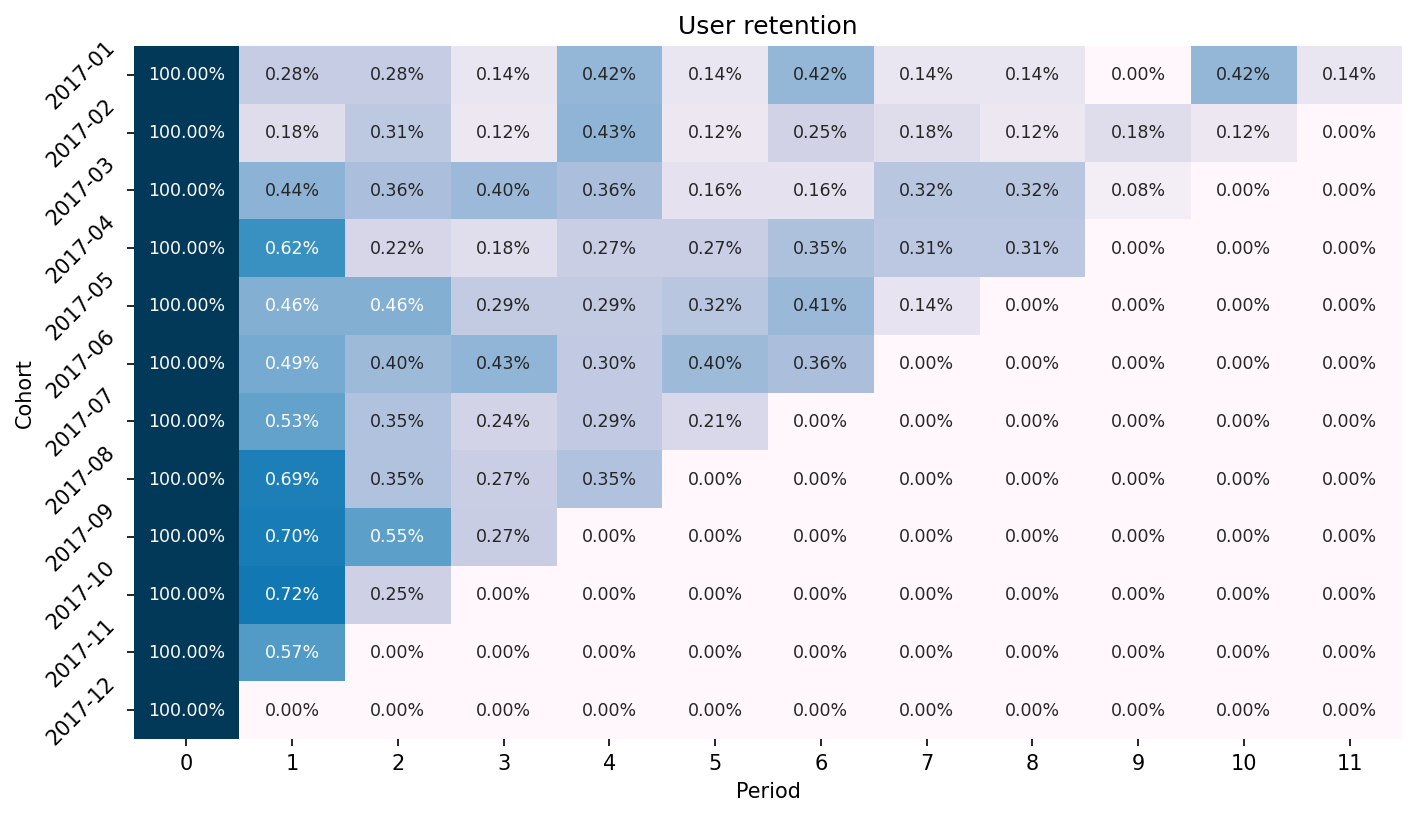

In [206]:
dpi = 150  # явно зададим DPI
fig, ax = plt.subplots(dpi=dpi, figsize=(1400/dpi, 800/dpi),
                       constrained_layout=True)
sns.heatmap(data=retention_table, annot=True, annot_kws={'size':'small'},
            fmt='.2%',
            vmin=0.0, vmax=0.01, cmap='PuBu', cbar=False, ax=ax)
ax.set(title='User retention', xlabel='Period', ylabel='Cohort')
ax.tick_params(axis='y', rotation=45)
plt.show()

# # Save the figure exactly as it appears inline
# fig.savefig('my_figure.png', bbox_inches='tight', dpi=fig.dpi)

In [207]:
print(f"Самый высокий показатель retention за третий месяц равен {np.round(100*retention_table[3].max(), 3)}%.",
      f"Он отвечает когорте {retention_table[3].idxmax()}.")

Самый высокий показатель retention за третий месяц равен 0.428%. Он отвечает когорте 2017-06.


In [208]:
# Удаляем ненужное
del (ax, cohorts_df, dpi, fig, filtered_orders_df, first_purchases,
     months, new_df, retention_table, temp_1, temp_2, years)

## Пункт 6
Выполнить RFM-сегментацию пользователей и провести качественную оценку аудитории.

RFM-сегментация подразумевает расчет параметров *Recency, Frequency и Monetary* для каждого пользователя:
* *Recency* - время с момента последней покупки пользователя до некоторой контрольной даты;
* *Frequency* - количество покупок, совершенных пользователем за весь период мониторинга;
* *Monetary* - общая сумма денег, потраченных пользователем за весь период мониторинга. 

Принимаемые этими параметрами значения разделяются на диапазоны, каждому из которых присваивается ранг от 1 до 4. Таким образом, любой пользователь описывается тремя цифрами, которые отвечают рангу его параметров *Recency, Frequency и Monetary*. 

Наконец, на основе этих RFM-значений и своей личной экспертизы аналитик объединяет пользователей в сегменты. Рассмотрение этих сегментов позволяет выявить инсайты о поведении пользователей и определиться с направлениями дальнейшей работы.

### Подготовка данных

Мы будем работать только с успешными покупками, которые определяются так же, как и в предыдущих пунктах.

In [259]:
filtered_orders_df = orders_df.query("order_status=='delivered'") \
    .dropna(axis='index', thresh=len(orders_df.columns)-1) \
    [['order_id', 'customer_id', 'order_purchase_timestamp']]  # только нужное
# конвертация string в datetime
filtered_orders_df['order_purchase_timestamp'] = pd.to_datetime(
    filtered_orders_df['order_purchase_timestamp']
) 
filtered_orders_df.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


Создадим таблицу **merged_df**, состоящую из **filtered_orders_df** с добавлением столбца *customer_unique_id* (уникальные идентификаторы клиентов).

In [260]:
merged_df = pd.merge(
    filtered_orders_df, customers_df[['customer_unique_id', 'customer_id']],
    how='inner', on='customer_id'
)[['customer_unique_id', 'customer_id', 'order_id', 'order_purchase_timestamp']]
merged_df.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


Добавим в **merged_df** колонку со стоимостью каждого заказа *order_id*, предварительно созданную посредством агрегирования в датафрейме **items_df**.

In [261]:
merged_df = pd.merge(
    merged_df,
    items_df.groupby(by='order_id', as_index=False).agg({'price': 'sum'}),
    how='inner', on='order_id'
)
merged_df.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,price
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90


Возьмем в качестве референса для расчета *Recency* самый "новый" timestamp, содержащийся в данных, сдвинутый на 24 часа вперед.

In [262]:
reference_date = merged_df['order_purchase_timestamp'].max() + timedelta(days=1)
# reference_date = reference_date.replace(hour=0, minute=0, second=0)
reference_date

Timestamp('2018-08-30 15:00:37')

Создадим колонку с числом дней, прошедших между заказами и эталонной датой, определенной выше.

In [263]:
merged_df['days_since_order'] = (
    reference_date - merged_df['order_purchase_timestamp']
).dt.days
merged_df.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,price,days_since_order
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99,332
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70,36
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90,22
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00,284
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90,197


Создадим DataFrame со столбцами *Recency, Frequency и Monetary*.

In [264]:
rfm_df = merged_df.groupby(by='customer_unique_id', as_index=False) \
    .agg({"days_since_order": "min", "price": ["count", "sum"]})
rfm_df.columns = pd.Index(['CustomerID','Recency', 'Frequency', 'Monetary'])
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


### Присвоение рангов значениям R, F, M

Прежде всего, визуализируем распределения полученных значений *Recency, Frequency и Monetary*

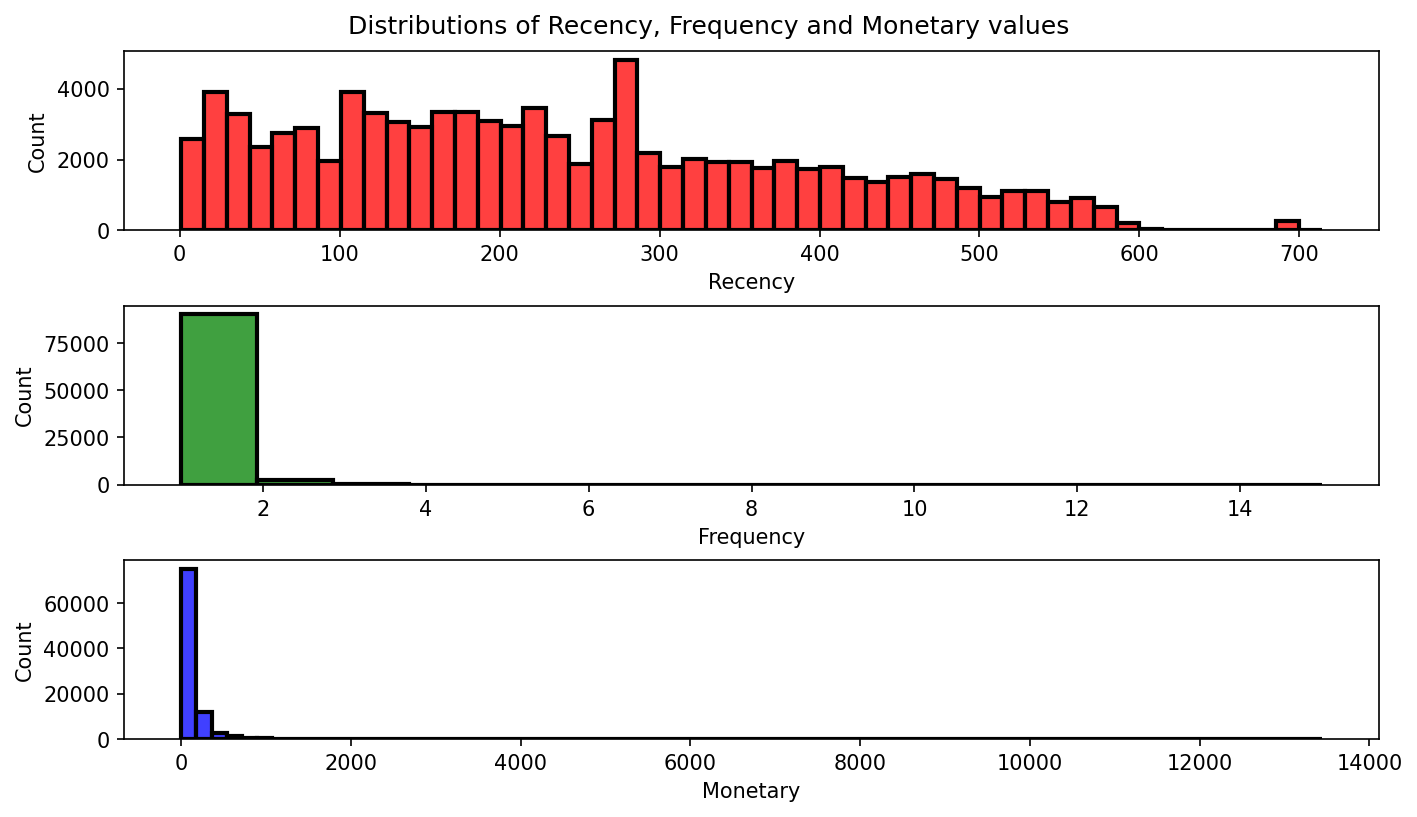

In [265]:
dpi = 150  # явно зададим DPI
fig, ax = plt.subplots(3, 1, dpi=dpi, figsize=(1400/dpi, 800/dpi),
                       constrained_layout=True)
fig.suptitle('Distributions of Recency, Frequency and Monetary values')
sns.histplot(data=rfm_df, x='Recency', color='red', bins=50,
             edgecolor="k", linewidth=2, ax=ax[0])
sns.histplot(data=rfm_df, x='Frequency', color='green', bins=15,
             edgecolor="k", linewidth=2, ax=ax[1])
sns.histplot(data=rfm_df, x='Monetary', color='blue', bins=75,
             edgecolor="k", linewidth=2, ax=ax[2])
plt.show()

#### Recency
Судя по графику, данные, принимающих целые значения от 1 до 714, отвечают распределению, близкому к экспоненциальному - наблюдается явная тенденция на уменьшение числа наблюдений с увеличением значения на оси абсцисс. В этом случае представляется вполне разумным использовать квартили выделения сегментов.

Найдем значения квартилей и нанесем их на гистограмму распределения *Recency*.

In [266]:
r_quartiles = rfm_df['Recency'].quantile(q=[0.25, 0.50, 0.75])
r_quartiles

0.25    114.0
0.50    219.0
0.75    346.0
Name: Recency, dtype: float64

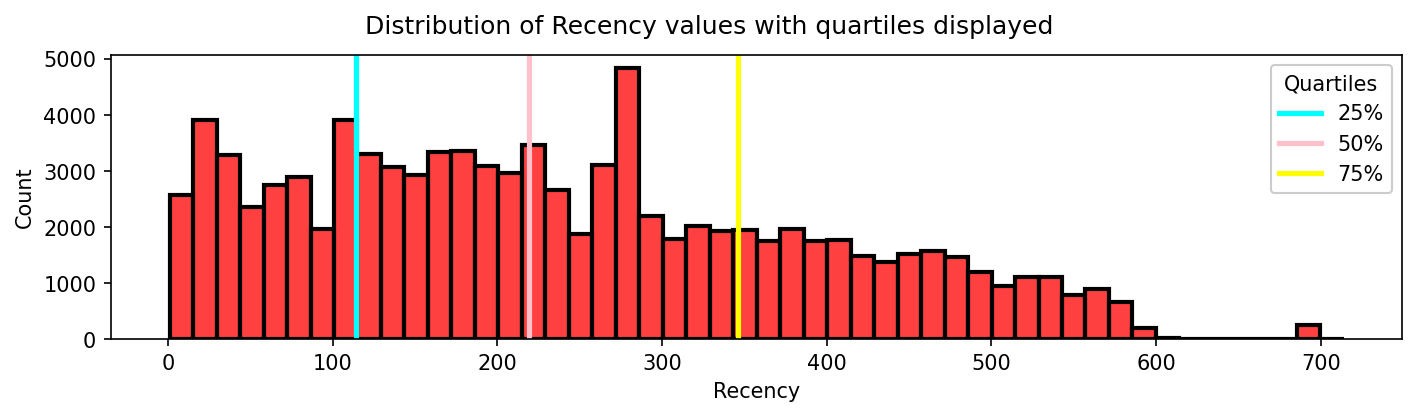

In [267]:
dpi = 150  # явно зададим DPI
clist = ['cyan', 'pink', 'yellow']  # список цветов для визуализации квартилей
#
fig, ax = plt.subplots(dpi=dpi, figsize=(1400/dpi, 400/dpi),
                       constrained_layout=True)
fig.suptitle('Distribution of Recency values with quartiles displayed')
sns.histplot(data=rfm_df, x='Recency', color='red', bins=50,
             edgecolor="k", linewidth=2, ax=ax)
for i in range(len(r_quartiles)):
    ax.axvline(x=r_quartiles.iloc[i], linewidth=2.5, color=clist[i],
               label=f'{int(100*r_quartiles.index[i])}%')
ax.legend(title='Quartiles', framealpha=1)
plt.show()

Первые три квартиля вполне сопоставимы по размеру вдоль оси х, четвертый же является более протяженным, "вытянутым влево".

In [268]:
def r_score(x, quartiles):
    '''
    Эта функция присваивает ранги от 1 до 4 значениям параметра Recency
    на основе квартилей его распределения.
    Чем больше значение, тем более низкий ранг ставится ему в соответствие.
    '''
    if x <= quartiles[0.25]:
        return 4
    elif x <= quartiles[0.50]:
        return 3
    elif x <= quartiles[0.75]:
        return 2
    else:
        return 1

#### Frequency
Из графика *Frequency* следует, что подавляющее число пользователей совершили по одной покупке.

Выведем все значения, которые принимает этот параметр, и подсчитаем, сколько раз каждое из них встречается в данных.

In [269]:
rfm_df['Frequency'].value_counts()

Frequency
1     90556
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64

In [270]:
rfm_df['Frequency'].nunique()

9

Квартили не являются разумным способом разбиения на диапазоны набора данных, состоящего из девяти целых значений, одно из которых встречается значительно чаще других.

В такой ситуации наиболее разумной представляется следующая схема "ручного" присвоения рангов:
* Frequency = 1 - ранг 1
* Frequency = 2 - ранг 2
* Frequency = 3 - ранг 3
* Frequency > 3 - ранг 4

In [271]:
def f_score(x):
    '''
    Эта функция присваивает ранг от 1 до 4 частоте x, причем более высокий ранг
    соответствует большей частоте.
    '''
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3: 
        return 3
    else:
        return 4

#### Monetary
Как и *Recency* с *Frequency*, значения *Monetary* отвечают экспоненциальному распределению. Но, в отличие от остальных параметров, в *Monetary* записаны числа с плавающей точкой, правый «хвост» распределения которых вытянут заметно сильнее, чем у *Recency* и *Frequency*.

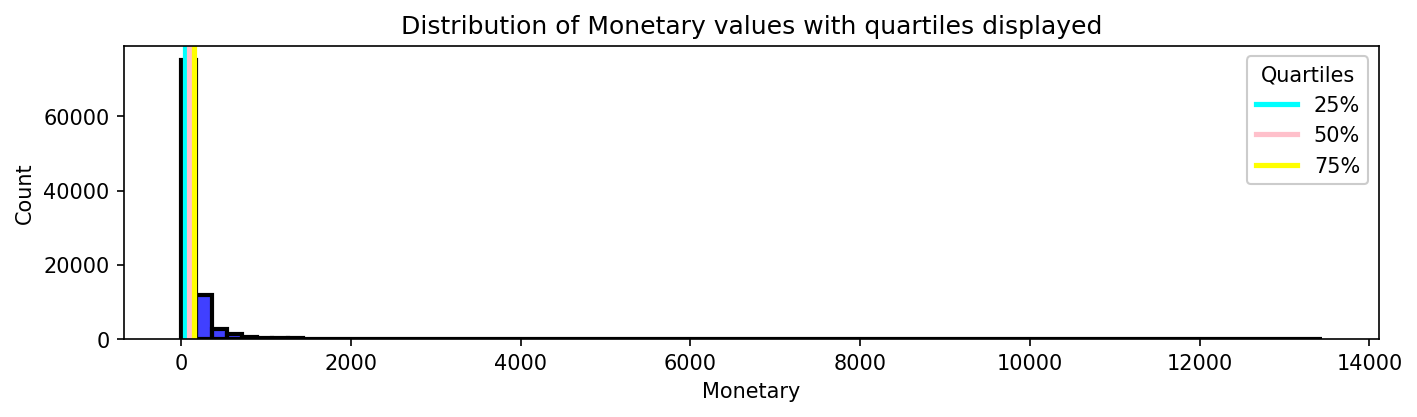

In [272]:
m_quartiles = rfm_df['Monetary'].quantile(q=[0.25, 0.50, 0.75])
dpi = 150  # явно зададим DPI
clist = ['cyan', 'pink', 'yellow']  # список цветов для визуализации квартилей
#
fig, ax = plt.subplots(dpi=dpi, figsize=(1400/dpi, 400/dpi),
                       constrained_layout=True)
ax.set_title('Distribution of Monetary values with quartiles displayed')
sns.histplot(data=rfm_df, x='Monetary', color='blue', bins=75,
             edgecolor="k", linewidth=2, ax=ax)
for i in range(len(m_quartiles)):
    ax.axvline(x=m_quartiles.iloc[i], linewidth=2.5, color=clist[i],
               label=f'{int(100*m_quartiles.index[i])}%')
ax.legend(title='Quartiles', framealpha=1)
plt.show()

Несмотря на результат визуализации, использование квартилей для разбиения данных на диапазоны представляется вполне разумным подходом.

In [273]:
def m_score(x, quartiles):
    '''
    Эта функция присваивает ранги от 1 до 4 значениям параметра Monetary
    на основе квартилей его распределения.
    Чем больше значение, тем больший ранг ставится ему в соответствие.
    '''
    if x <= quartiles[0.25]:
        return 1
    elif x <= quartiles[0.50]:
        return 2
    elif x <= quartiles[0.75]:
        return 3
    else:
        return 4

**Sidenote: логарифмическое преобразование.**
<br>Многие инструменты статистического анализа (например, t-тесты) основываются на предположении, что используемые данные имеют распределение, близкое к нормальному. Однако в реальной жизни это предположение зачастую не выполняется.
<br>Если экспериментальные данные подчиняются экспоненциальному распределению, то значения, полученные при помощи их логарифмического преобразования, будут соответствовать распределению, близкому к нормальному. Это позволяет применять все методы анализа, требующие соблюдения условия нормальности, к преобразованному описанным способом набору данных.

Возьмем натуральный логарифм наших значений *Monetary* и оценим, насколько результат этого преобразования соответствует нормальному распределению. Для этого построим гистограмму и QQ-график *ln(Monetary)*, а также выполним статистический тест Д'Агостино-Пирсона.

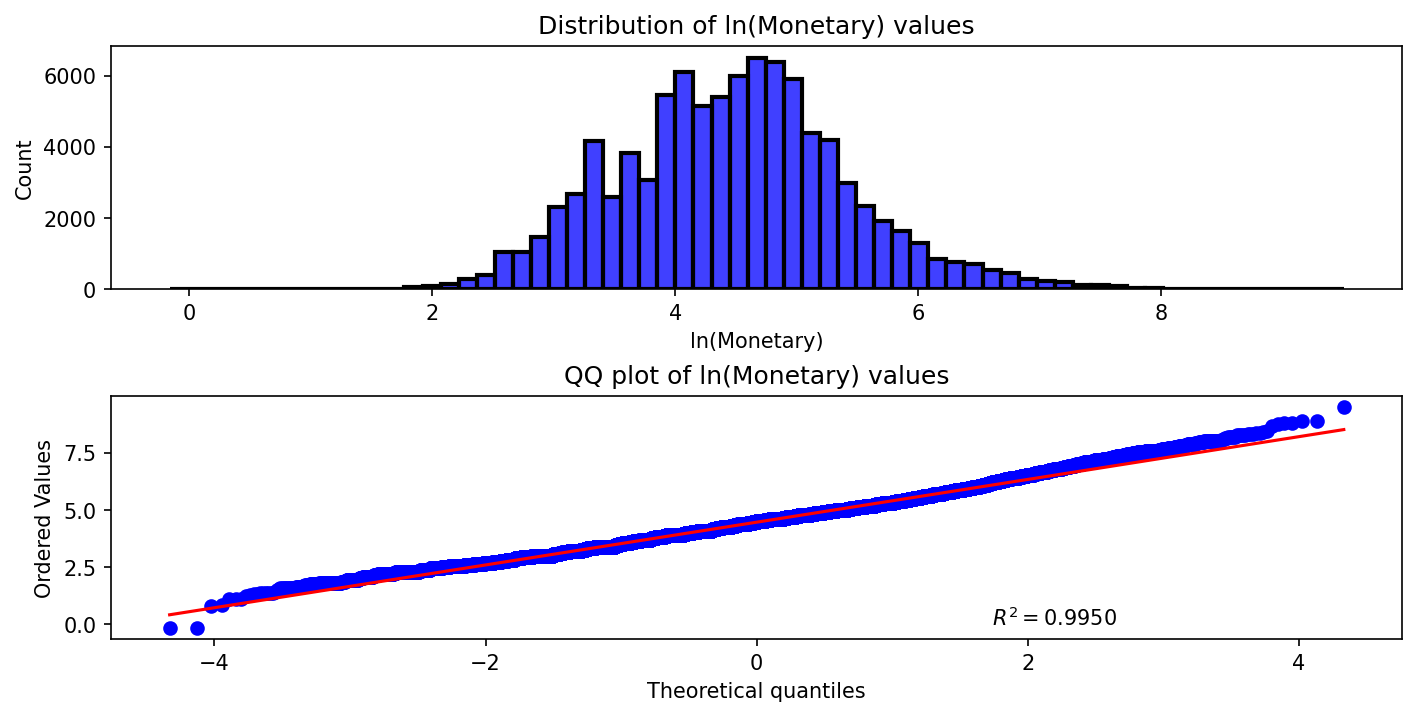

In [274]:
ln_m = np.log(rfm_df['Monetary'])  # pandas Series
dpi = 150  # явно зададим DPI
#
fig, ax = plt.subplots(2, 1, dpi=dpi, figsize=(1400/dpi, 700/dpi),
                       constrained_layout=True)
ax[0].set(title='Distribution of ln(Monetary) values',
       xlabel='ln(Monetary)')
sns.histplot(data=ln_m, color='blue', bins=65, edgecolor="k", linewidth=2,
             ax=ax[0])
stats.probplot(x=ln_m, dist='norm', fit=True, plot=ax[1],
               rvalue=True)
ax[1].set(title='QQ plot of ln(Monetary) values')
plt.show()

Визуальный анализ графиков свидетельствует о том, что распределение лог-трансформированных данных действительно близко к распределению Гаусса. Так, коэффициент детерминации $R^2$, показывающий, какой процент дисперсии значений *ln(Monetary)* объясняется сопоставлением с нормальным распределением, составляет 99,5%.

In [275]:
stats.normaltest(ln_m)

NormaltestResult(statistic=1132.527163696627, pvalue=1.1880948148335366e-246)

Крайне низкое р-значение, полученное в результате теста Д'Агостино-Пирсона, говорит о том, что нулевая гипотеза (данные отвечают нормальному распределению) должна быть отброшена в пользу альтернативной. Что противоречит результатам визуального анализа гистограммы и QQ-графика. Причиной такого расхождения может быть крайне высокая чувствительность теста, которая, при большом размере выборки (в нашем случае - 93357), приводит к очень низкому p-значению даже при небольших отклонениях от нормальности.

Поскольку большая часть значений на QQ-графике выстраивается вдоль диагональной fit-линии, трансформированные данные можно считать достаточно нормальными для применения требующих соблюдения этого условия инструментов статистического анализа.
**Конец sidenote**

Рассчитаем ранги *R, F, M*, сохраним их в датафрейме **rfm_df**, и, наконец, объединим их в итоговый показатель *RFM*.

In [276]:
rfm_df['R'] = rfm_df['Recency'].apply(r_score, args=(r_quartiles,))
rfm_df['F'] = rfm_df['Frequency'].apply(f_score)
rfm_df['M'] = rfm_df['Monetary'].apply(m_score, args=(m_quartiles,))
rfm_df['RFM'] = (rfm_df['R'].astype(str) + rfm_df['F'].astype(str)
                 + rfm_df['M'].astype(str)).astype(int)
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3,413
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214


In [277]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  93357 non-null  object 
 1   Recency     93357 non-null  int64  
 2   Frequency   93357 non-null  int64  
 3   Monetary    93357 non-null  float64
 4   R           93357 non-null  int64  
 5   F           93357 non-null  int64  
 6   M           93357 non-null  int64  
 7   RFM         93357 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 5.7+ MB


### Выделение сегментов

На основе анализа полученной таблицы предлагается разделить пользователей на следующие 7 сегментов:

| Сегмент | Описание |
|----------|----------|
| Чемпионы | Совершили свою последнюю покупку сравнительно недавно, при этом покупают чаще и тратят больше всех |
| Лояльные клиенты | Совершили свою последнюю покупку сравнительно недавно, в общей сложности сделали 2-3 покупки и потратили больше денег, чем средний клиент |
| Потенциальные лоялисты | Схожи с лояльными клиентами, но потратили меньше среднего |
| Спящие | Совершили свою последнюю покупку очень давно |
| Скоро уснут | Схоже с "спящими" клиентами, но их последняя покупка была совершена ближе к контрольной дате |
| Новые клиенты | Недавно совершившие свою первую покупку |
| Требуют внимания | Совершили только одну покупку, причем относительно недавно (но раньше, чем новые клиенты)|

In [278]:
segments = {
    r'[3-4]44': 'Чемпионы',
    r'[3-4][2-3][3-4]': 'Лояльные клиенты',
    r'[3-4][2-3][1-2]': 'Потенциальные лоялисты',
    r'1[1-4][1-4]': 'Спящие',
    r'2[1-4][1-4]': 'Скоро уснут',
    r'41[1-4]': 'Новые клиенты',
    r'31[1-4]': 'Требуют внимания',
}

rfm_df['Segment'] = rfm_df['RFM'].astype(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segments, regex=True)

Проверим, всем ли клиентам был присвоен сегмент.

In [279]:
 rfm_df['Segment'].unique()

array(['Новые клиенты', 'Требуют внимания', 'Спящие', 'Скоро уснут',
       'Потенциальные лоялисты', 'Лояльные клиенты', 'Чемпионы'],
      dtype=object)

Сколько пользователей попало в тот или иной сегмент?

In [280]:
rfm_df['Segment'].value_counts()

Segment
Спящие                    23310
Скоро уснут               23200
Требуют внимания          22685
Новые клиенты             22613
Лояльные клиенты           1279
Потенциальные лоялисты      233
Чемпионы                     37
Name: count, dtype: int64

In [281]:
temp = rfm_df['Segment'].value_counts()

(temp['Лояльные клиенты'] + temp['Потенциальные лоялисты']) / temp.sum()

0.016195893184228285

In [282]:
temp['Новые клиенты']/ temp.sum()

0.24222072260248295

### Выводы
**1. Около половины клиентов относятся к сегментам «спящие» и «скоро уснут».**
<br>Большое число клиентов либо уже потеряли интерес к продукту, либо находятся на грани этого. Необходимо принять меры для их повторной активации, например, посредством специальных предложений или персонализированных рекламных кампаний.
<br>**2. 24.3% клиентов «требуют внимания».**
<br>Они совершили свою первую и единственную покупку относительно недавно, в период от 115 до 219 дней до контрольной даты. Важно не дать им «уснуть» и вовлечь в регулярные покупки, возможно, предложив им выгодные условия на следующую покупку или программы лояльности.
<br>**3. 24.2% клиентов являются новыми.**
<br>Сегмент «новые клиенты», к которому относятся пользователи, совершившие первую покупку в период до 114 дней до контрольной даты, также весьма значителен по размеру. Это свидетельствует о большом притоке новых покупателей. Следует заниматься их удержанием, предлагая высококачественное обслуживание и продукты, а также искать механизмы их перемещения в сегменты "потенциальные лоялисты" и более высокие.
<br>**4. «Потенциальные лоялисты» и «лояльные клиенты» составляют 1.6% от общего числа клиентов.**
<br>Необходимо изучить, что удерживает этих клиентов, и попытаться расширить данные сегменты. Возможно, стоит персонализировать предложения и/или усилить поддержку для этих клиентов, чтобы не потерять их.
<br>**5. Всего 37 клиентов являются «чемпионами».**
<br>Это самые ценные клиенты, но их, к сожалению, крайне мало относительно общего числа. Нужно уделять им особое внимание, чтобы они продолжали покупать чаще и больше остальных, а также могли становиться амбассадорами бренда.

Таким образом, текущая картина показывает наличие как значительных рисков (большое количество "спящих" и "скоро уснут" клиентов), так и возможностей для роста (большое количество новых клиентов и клиентов, требующих внимания).

In [283]:
# Удаляем ненужное
del (
    ax, clist, dpi, fig, filtered_orders_df, i, ln_m, m_quartiles, m_score, temp,
    segments, rfm_df, reference_date, r_quartiles, merged_df
) 